<h1 align="center"><font color="yellow">Pytorch: otimizado</font></h1>

<font color="yellow">Data Scientist.: PhD.Eddy Giusepe Chirinos Isidro</font>

<font color="orange">Usaremos o conjunto de dados [MNIST](http://deeplearning.net/data/mnist/) clássico, que consiste em imagens em preto e branco de dígitos desenhados à mão (entre $0$ e $9$).</font>

# Configurando os Dados MNIST

In [ ]:
%conda install requests,matplotlib --yes

In [1]:
%load_ext watermark 
%watermark -v -p numpy,pandas,matplotlib,requests

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.13.2

numpy     : 1.24.3
pandas    : 2.0.1
matplotlib: 3.7.1
requests  : 2.31.0



In [2]:
from pathlib import Path
import requests


DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)
        

Este conjunto de dados está no formato de matriz numpy e foi armazenado usando pickle, um formato específico do python para serializar dados.

In [3]:
import pickle
import gzip


with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
        

<font color="orange">Cada imagem tem $28$x$28$ e está sendo armazenada como uma linha achatada de comprimento `784 (=28 x 28)`. Vamos dar uma olhada em um; precisamos remodelá-lo para 2d primeiro.</font>

(50000, 784)


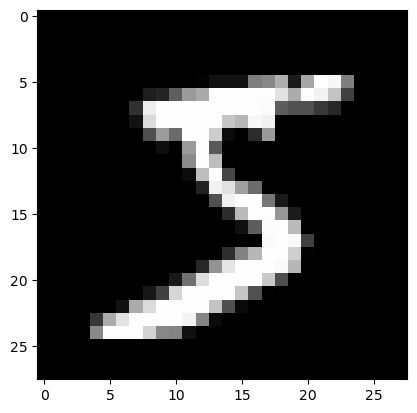

In [4]:
from matplotlib import pyplot
%matplotlib inline

import numpy as np


pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

PyTorch usa `torch.tensor`, em vez de `arrays numpy`, então precisamos converter nossos dados.

In [5]:
import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))


In [6]:
n, c = x_train.shape


In [7]:
n

50000

In [8]:
c

784

In [9]:
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


# <font color="red">Rede Neural do Zero (`sem torch.nn`)</font>

Você pode lembrar no [course.fast.ai](https://course.fast.ai/) os Fundamentos das Redes Neurais.


O `PyTorch` fornece métodos para criar `tensores aleatórios` ou `preenchidos com zero`, que usaremos para criar nossos `pesos` e `viés` para um modelo linear simples. Estes são apenas tensores regulares, com uma adição muito especial: dizemos ao PyTorch que eles `requerem um gradiente`. Isso faz com que o PyTorch registre todas as operações feitas no tensor, para que possa calcular o `gradiente durante a retropropagação` automaticamente!

Para os pesos, definimos `requires_grad` após a inicialização, pois não queremos essa etapa incluída no gradiente. (Observe que um rastro `_` no `PyTorch` significa que a operação é executada no local.)

In [10]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)


Graças à capacidade do `PyTorch` de calcular `gradientes` automaticamente, podemos usar qualquer função `Python` padrão (ou objeto chamável) como modelo! Então, vamos apenas escrever uma multiplicação de matriz simples e uma adição transmitida para criar um modelo linear simples. Também precisamos de uma `função de ativação`, então vamos escrevê-la `log_softmax` e usá-la. Lembre-se: embora o `PyTorch` forneça muitas funções de perda pré-escritas, funções de ativação e assim por diante, você pode escrever facilmente usando python simples. O `PyTorch` criará até código de `GPU` rápido ou código de `CPU` vetorizado para sua função automaticamente.

In [11]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)


Acima, o `@` representa a operação de multiplicação de matrizes. Chamaremos nossa função em um batch de dados (neste caso, `64` imagens). Este é um `forward pass`. Observe que nossas previsões não serão melhores do que aleatórias neste estágio, pois começamos com pesos aleatórios.

In [12]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape

print(preds[0], preds.shape)

tensor([-2.2808, -2.5022, -2.2217, -2.1810, -1.8906, -2.2005, -2.4440, -2.3127,
        -2.4598, -2.7878], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [15]:
def nll(input, target):
    """Probabilidade Logarítmica negativa para usar como Loss."""
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [16]:
loss_func

<function __main__.nll(input, target)>

Vamos verificar nossa Loss com nosso modelo aleatório, para que possamos ver se melhoramos depois de um passe de backprop posteriormente.

In [17]:
yb = y_train[0:bs]
print(loss_func(preds, yb))


tensor(2.3751, grad_fn=<NegBackward0>)


In [18]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()


In [19]:
print(accuracy(preds, yb))


tensor(0.0625)


In [20]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # Épocas para treinar

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
            

É isso: criamos e treinamos uma rede neural mínima (no caso, uma `regressão logística`, já que não temos camadas ocultas) inteiramente do zero!

Vamos verificar a LOSS e a Accuracy e compará-los com o que obtivemos anteriormente. Esperamos que a Loss tenha diminuído e a Accuracy tenha aumentado, e eles têm:

In [21]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0822, grad_fn=<NegBackward0>) tensor(1.)


# <font color="red">Usando `torch.nn.functional`</font>

Vamos agora refatorar nosso código, para que faça a mesma coisa de antes, só que começaremos a aproveitar as classes `nn` do `PyTorch` para torná-lo mais `conciso` e `flexível`. Em cada etapa a partir daqui, devemos tornar nosso código um ou mais dos seguintes: `mais curto`, `mais compreensível` e/ou `mais flexível`.

A primeira e mais fácil etapa é tornar nosso código mais curto, `substituindo` nossas `funções de ativação` e `perda` manuscritas por aquelas de `torch.nn.functional` (que geralmente são importadas para o namespace `F` por convenção). Este módulo contém todas as funções da biblioteca `torch.nn` (enquanto outras partes da biblioteca contêm classes). Além de uma ampla `variedade de funções de Loss` e `ativação`, você também encontrará aqui algumas funções convenientes para criar redes neurais, como funções de `pooling`. (Também existem funções para fazer `convoluções`, `camadas lineares`, etc, mas como veremos, elas geralmente são mais bem tratadas usando outras partes da biblioteca.)

Se você estiver usando `Loss de probabilidade de log negativo` (**negative log likelihood loss**) e ativação de `softmax de log`, o Pytorch fornece uma única função `F.cross_entropy` que combina os dois. Assim, podemos até remover a função de ativação do nosso modelo.

In [22]:
import torch.nn.functional as F

"""A função 'cross_entropy' combina a função de perda logarítmica (também conhecida como entropia cruzada) com 
a aplicação da função 'softmax' às saídas do modelo. Ela calcula a perda entre as previsões do modelo e os rótulos 
verdadeiros do conjunto de dados."""
loss_func = F.cross_entropy


def model(xb):
    return xb @ weights + bias

Observe que não chamamos mais `log_softmax` a `model` função. Vamos confirmar que nossa `perda` e `accuracy` são as mesmas de antes:

In [23]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0822, grad_fn=<NllLossBackward0>) tensor(1.)


# Refatorar usando `nn.Module`

Em seguida, usaremos `nn.Module` e `nn.Parameter`, para um loop de treinamento mais claro e conciso. Subclassificamos `nn.Module` (que em si é uma classe e capaz de acompanhar o estado). Nesse caso, queremos criar uma classe que contenha nossos `pesos`, `viés` e método para o próximo passo. `nn.Module` tem vários atributos e métodos ( como `.parameters()` e `.zero_grad()` ) que usaremos.


<font color="red">OBS:</font>

`nn.Module` (`M` maiúsculo) é um conceito específico do `PyTorch` e é uma classe que usaremos muito. `nn.Module` não deve ser confundido com o conceito `Python` de um módulo (`m` minúsculas ), que é um arquivo de código Python que pode ser importado.

In [24]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias
    

Como agora estamos usando um objeto em vez de apenas uma função, primeiro temos que instanciar nosso modelo:

In [25]:
model = Mnist_Logistic()

In [26]:
print(loss_func(model(xb), yb))


tensor(2.2934, grad_fn=<NllLossBackward0>)


Anteriormente, para nosso loop de treinamento, tínhamos que atualizar os valores de cada parâmetro por nome e zerar manualmente as grads de cada parâmetro separadamente, assim:


```
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()
```

Agora podemos aproveitar `model.parameters()` e `model.zero_grad()` (ambos definidos pelo `PyTorch` para `nn.Module`) para tornar essas etapas mais concisas e menos propensas ao erro de esquecer alguns de nossos parâmetros, especialmente se tivermos um modelo mais complicado:


```
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```



Vamos envolver nosso pequeno loop de treinamento em uma função `fit` para que possamos executá-lo novamente mais tarde.

In [27]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

Vamos verificar novamente se nossa perda diminuiu:

In [28]:
print(loss_func(model(xb), yb))

tensor(0.0794, grad_fn=<NllLossBackward0>)


# <font color="red">Refatorar usando `nn.Linear`</font>

Continuamos a refatorar nosso código. Em vez de definir e inicializar manualmente `self.weights` e `self.bias`, e calcular `xb @ self.weights + self.bias`, usaremos a classe Pytorch [nn.Linear](https://pytorch.org/docs/stable/nn.html#linear-layers) para uma camada linear, que faz tudo isso para nós. O Pytorch tem muitos tipos de camadas predefinidas que podem simplificar muito nosso código e, muitas vezes, torná-lo mais rápido também.

In [29]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10) # Camada Linear (totalmente conectada). 28x28 = 784 e 10 são o número de classes de saída (MNIST --> 0 - 9).

    def forward(self, xb):
        return self.lin(xb)



Instanciamos nosso modelo e calculamos a Loss da mesma forma que antes:

In [30]:
model = Mnist_Logistic()

print(loss_func(model(xb), yb))


tensor(2.4087, grad_fn=<NllLossBackward0>)


Ainda podemos usar nosso mesmo método `fit` de antes.

In [31]:
fit()

In [32]:
print(loss_func(model(xb), yb))

tensor(0.0806, grad_fn=<NllLossBackward0>)
